In [1]:
import sys, os
parent_dir = os.path.abspath('..')
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from particles import distributions as dists
from particles import state_space_models as ssm
from particles import smc_samplers as smp
from particles import kalman
from particles import resampling
from particles import mcmc
from particles import rao_blackwell
from particles import plotting_util
import particles
import corner
from math import sqrt, cos, sin, pi
import seaborn as sb
import matplotlib as mpl
mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "text.latex.preamble": r"\usepackage{amsmath}",
})
np.random.seed(2)

Create the state space model class for Active Brownian Motion

In [2]:
D0 = 2.0
Drot = 0.5
Dobs = 0.25
dt = 0.1

class ABM(rao_blackwell.RBMVLinearGauss):
    def __init__(self, **kwargs):
        default_parameters = {'D0': D0, 'Drot': Drot, 'Dobs': Dobs}
        self.__dict__.update(default_parameters)
        self.__dict__.update(kwargs)
        A = lambda w: np.array([[1., 0., dt*cos(w)],[0., 1., dt*sin(w)],[0.,0.,1.]])
        H = lambda w: np.array([[1,0,0],[0,1,0]])
        Gamma = lambda w: np.diag([(2*dt*self.D0),(2*dt*self.D0),0.00001])
        Sigma = lambda w: np.eye(2)*self.Dobs
        m0 = lambda w: np.array([0.,0.,20.])
        cov0 = lambda w: np.diag([5.,5.,10.])
        PW0 = dists.Uniform(0, 2*pi)
        def PW(t, wp):
            return dists.Normal(loc=wp, scale=sqrt(self.Drot))
        rao_blackwell.RBMVLinearGauss.__init__(self,PW0, PW, A, H, Gamma, Sigma, m0, cov0)



Create some data

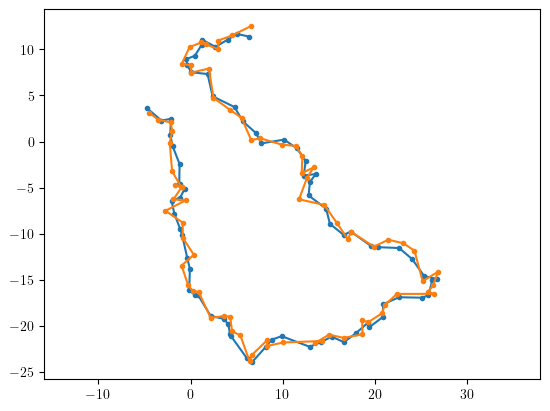

In [3]:
myRB_nd = ABM()
N_sim = 75
xs, ys = myRB_nd.simulate(N_sim)
xs = np.vstack(xs).flatten()
ys = np.vstack(ys)

plt.figure()
plt.plot(xs['z'][:,0], xs['z'][:,1], '.-')
plt.plot(ys[:,0], ys[:,1], '.-')
plt.axis("equal");

In [4]:
case = "Drot_D0_Dobs"
    
if case == "Drot_D0_Dobs": # in this case, we infer Drot, D0, and Dobs
    prior_dict = {'D0': dists.Gamma(),
          'Drot': dists.Gamma(),
          'Dobs':dists.Gamma()}
    true_vals = [D0, Drot, Dobs]
else: # in this case we only infer Drot and D0, assuming Dobs to be known
    prior_dict = {'D0': dists.Gamma(),
          'Drot': dists.Gamma()}
    true_vals = [D0, Drot]
my_prior = dists.StructDist(prior_dict)

Running PMMH for parameter estimation

In [5]:
my_pmmh = mcmc.PMMH(ssm_cls=ABM, fk_cls=rao_blackwell.Bootstrap_RaoBlackwell, prior=my_prior, data=ys, Nx=300,  niter=10000, verbose=10)
my_pmmh.run()

Iteration 0, 2025-07-30 11:31:30.635720, D0=2.796371446020272, Dobs=0.36574916976598704, Drot=0.19981949466651255
Iteration 10, 2025-07-30 11:31:49.492709, acc. rate=0.300, D0=3.5957033243352683, Dobs=0.19213794289905933, Drot=0.07431849595411714
Iteration 20, 2025-07-30 11:32:17.368609, acc. rate=0.300, D0=2.7889228107385207, Dobs=0.16196112542032884, Drot=0.12347176298870949
Iteration 30, 2025-07-30 11:32:50.886327, acc. rate=0.367, D0=2.8984715322427985, Dobs=0.16613201629800178, Drot=0.10036019701942711
Iteration 40, 2025-07-30 11:33:28.864973, acc. rate=0.400, D0=2.5559977340390434, Dobs=0.2468140573055283, Drot=0.12922492926064272
Iteration 50, 2025-07-30 11:34:07.895201, acc. rate=0.460, D0=1.957778613603334, Dobs=0.2773986226600301, Drot=0.2528338968301694
Iteration 60, 2025-07-30 11:34:43.909367, acc. rate=0.433, D0=2.832262632768848, Dobs=0.25950353178812363, Drot=0.17788867042470805
Iteration 70, 2025-07-30 11:35:23.100854, acc. rate=0.500, D0=2.015513207402525, Dobs=0.25855

Show caterpillar plots for all parameters

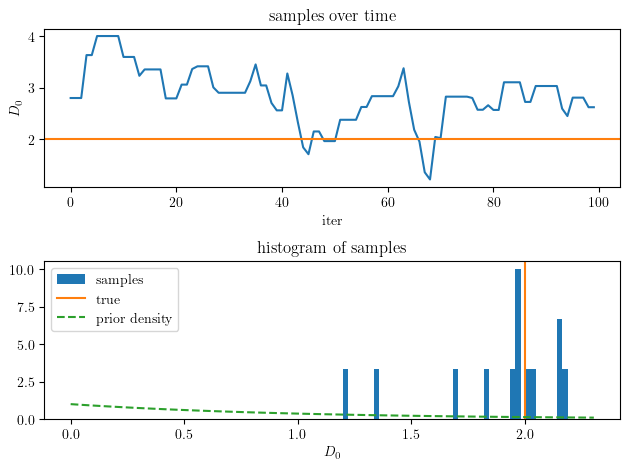

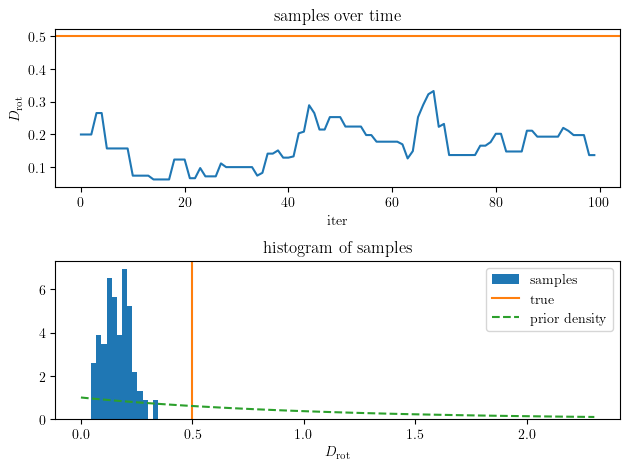

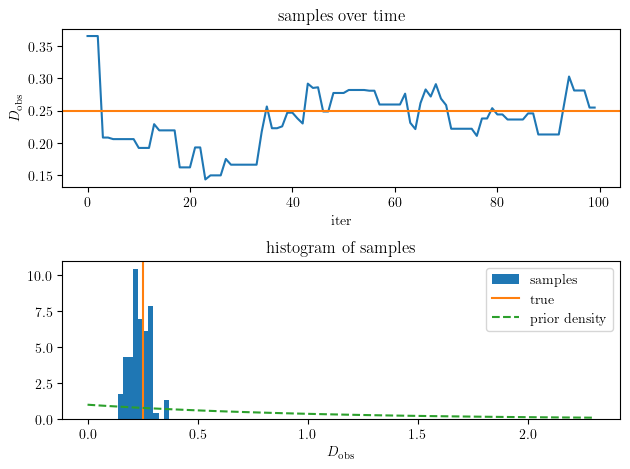

In [6]:
label_axis = ["$D_0$", "$D_{\\text{rot}}$", "$D_{\\text{obs}}$"]
for mm, p in enumerate(prior_dict.keys()):  # loop over all inferred parameters
        plotrange = np.linspace(0, max(prior_dict[p].ppf(0.9),true_vals[mm]*1.1), 100)
        plt.figure()
        plt.subplot(211)
        plt.plot(my_pmmh.chain.theta[p], label="samples")
        plt.axhline(true_vals[mm], color="tab:orange", label="true")
        plt.xlabel('iter')
        plt.ylabel(label_axis[mm])
        plt.title("samples over time")
        plt.subplot(212)
        plt.hist(my_pmmh.chain.theta[p], 100, range=(plotrange[0],plotrange[-1]), density=True, label="samples")
        plt.axvline(true_vals[mm], color="tab:orange", label="true")
        plt.plot(plotrange, prior_dict[p].pdf(plotrange), '--', color="tab:green", label="prior density")
        plt.xlabel(label_axis[mm])
        plt.title("histogram of samples")
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"caterpillar_{p}.png", dpi=300)

choose a burn-in iteration (to be taken visually from the caterpillar plot above), and show a corner plot after burn-in

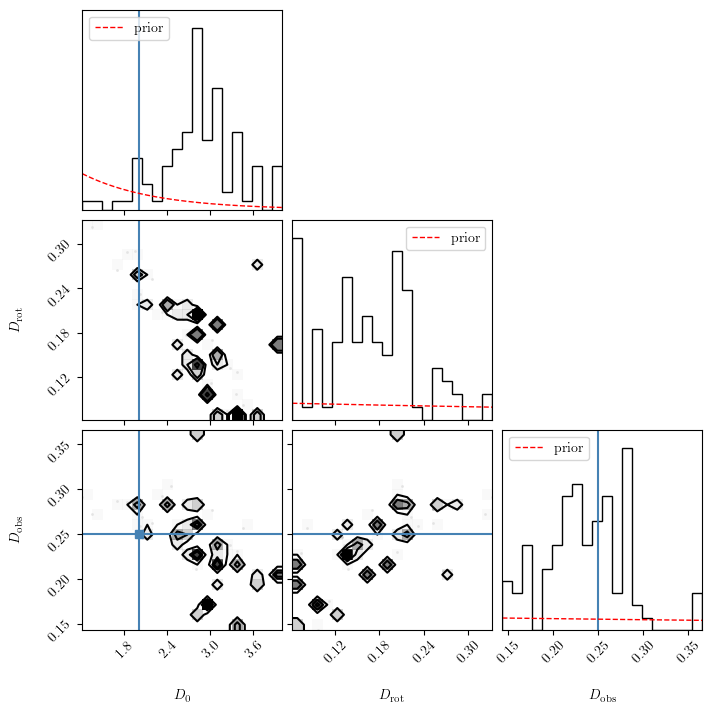

In [8]:
array_samples = np.stack([my_pmmh.chain.theta[p] for p in prior_dict.keys()])
N_burnin = 0
array_samples_burnin = array_samples[:,N_burnin:]

plotting_util.extended_corner(array_samples_burnin, prior_dict, None, true_vals, param_labels=["$D_0$", "$D_{\\text{rot}}$", "$D_{\\text{obs}}$"])  
plt.savefig("corner_ABP_groundtruth.png", dpi=300)

do state inference

In [9]:
myBootRB = rao_blackwell.Bootstrap_RaoBlackwell(myRB_nd, ys)
pf = particles.SMC(fk=myBootRB, N=1000, store_history=True)
pf.run()


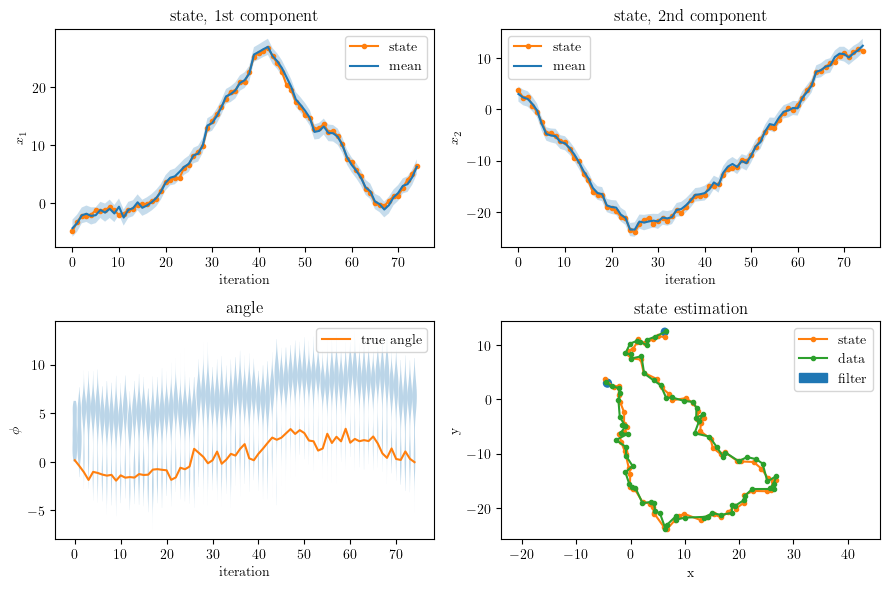

In [10]:
plotting_util.ABP_plot_thetaPart_small(pf, pf.wgts, xs=xs, ys=ys, k=len(ys)-1)
plt.savefig("state_inference_ABP.png", dpi=300)

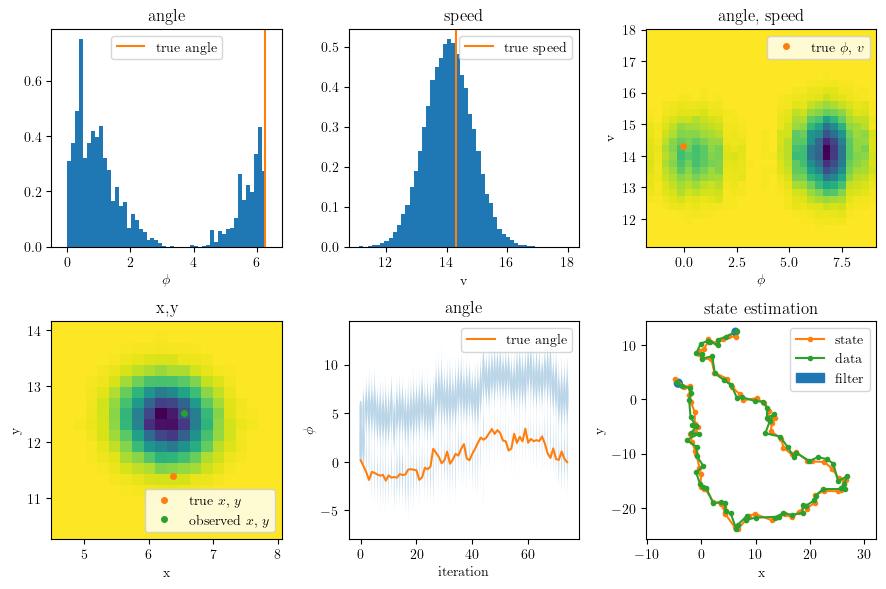

In [11]:
plotting_util.ABP_plot_thetaPart(pf, pf.wgts, xs=xs, ys=ys, k=len(ys)-1)

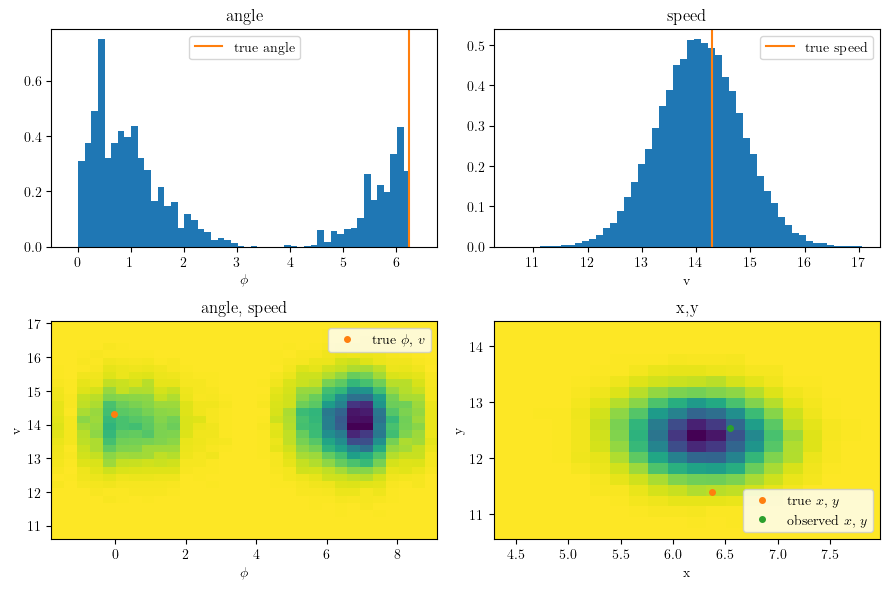

In [12]:
plotting_util.ABP_plot_thetaPart_final(pf, pf.wgts, xs=xs, ys=ys, k=len(ys)-1)
plt.savefig("state_inference_final_ABP.png", dpi=300)